In [1]:
import proposal as pp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14

In [2]:
pp.InterpolationSettings.tables_path = "/tmp" # save interpolation tables to folder

# Propagator
The propagator object combines all interaction utilies to a complete propagation. It can be used to simulate all interactions of a particle, defined by its initial state, until a break condition has been reached. 

## Initializing the propagator using a configuration file
The easiest way to intialize a propagator object is by using a *json configuration file* with the command

```
pp.Propagator(particle_def, path_to_config_file)
```

A documentation of the configuration file is given by the file *config_docu.md*

## Initializing the propagator manually with Python objects
Alternatively, one can define the propagator manually by creating all necessary python objects.
In this example, we will use this way to illustrate the way the propagator works.

In general, every propagator consists out of several *Sectors*. Each sector is defined by its *Geometry*, its *density distribution* and its *PropagationUtility*, which is a combination of all utilities that will be used in the sector.
By having different sectors, the user can define different propagation behaviours in different parts of the propagation environment (for example a higher precision in the vicinity of the detector, different crosssections for different media, ...).

### Defining the crosssections
Firstly, we need to define the crosssections providing the physical input for our utilities.
We can either use a custom combination of parametrizations or use the particle-dependent standard crossections provided by PROPOSAL (*see the CrossSection example for more information on how to use custom parametrizations*)

*Running the following cell for the first time will take some time since interpolation tables need to be built*

In [3]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.Ice(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(np.inf, 0.05, False)
}

cross = pp.crosssection.make_std_crosssection(**args) # use the standard crosssections

### Defining our utilities
We can now define our utilities: *Continuous randomization*, *Decay*, *Interaction*, *Displacement*, *Scattering* and *Time*. Interaction, Displacement and Time are mandatory, all other propagation utilities are optional (*see the individual example for more information on the utilities*).

For our example, we stick to the mandatory utilities. For each utilitiy, we can decide whether we want to create interpolation tables or not (for particle propagation, we usually want interpolation tables to be built, otherwise propagation will be significantly slower!)

In [4]:
collection = pp.PropagationUtilityCollection()

collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)

utility = pp.PropagationUtility(collection = collection)

### Defining our geometry and our density distribution
We just choose a big sphere as our geometry, our density distribution is homogeneous.
Here, we could also choose an inhomogeneous density distribution - PROPOSAL provides different models to parametrize inhomogeneities.

In [5]:
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20)
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)

### Putting together our propagator
We can now out together our propagator, in this example only consisting out of one sector. One can easily add additional sectors by adding more combinations of detector, utility and density_distribution objects.

In [6]:
prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

## Propagating
We can use the `propagate()` function to propagate a particle defined by its initial state.
We can pass a break condition: Either a maximal distance to be propagated or a minimal energy where the propagation will be stopped. If no break condition is passed to the propagator, the particle will propagate until it did decay, have a fatal interaction (e.g. annihilation for positrons) or reached has reached its rest mass.

### Energy distribution after a fixed distance
Assuming a fixed initial particle energy, how does the energy distribution look like after the particle has been propagated for a fixed distance?

First, we need to define an initial state:

In [7]:
init_state = pp.particle.ParticleState()
init_state.energy = 1e9 # initial energy in MeV
init_state.position = pp.Cartesian3D(0, 0, 0)
init_state.direction = pp.Cartesian3D(0, 0, 1)

100%|██████████| 100000/100000 [00:00<00:00, 144095.44it/s]


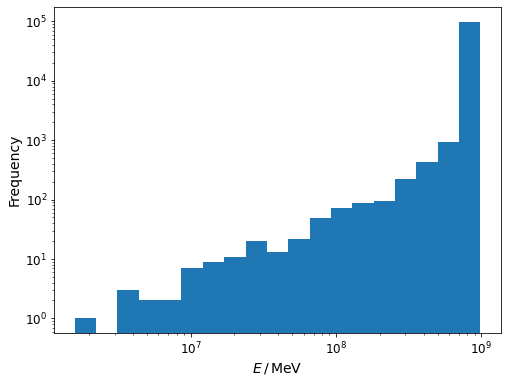

In [8]:
STATISTICS = int(1e5)
energies = []

for i in tqdm(range(STATISTICS)):
    track = prop.propagate(init_state, 1e4) # propagate the initial state for 1e4 cm
    energy_at_track_end = track.track_energies()[-1] # save energy at the end of the track
    energies.append(energy_at_track_end)
    
bins = np.geomspace(min(energies), max(energies), 20)
plt.xscale('log')
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel("Frequency")
_ = plt.hist(energies, bins=bins, log=True) 

### Distance distribution at a fixed energy
Assuming a fixed initial particle energy, how long did the particle propagate to reach a fixed final energy?

In [9]:
init_state = pp.particle.ParticleState()
init_state.energy = 1e6 # initial energy in MeV
init_state.position = pp.Cartesian3D(0, 0, 0)
init_state.direction = pp.Cartesian3D(0, 0, 1)

100%|██████████| 10000/10000 [00:00<00:00, 34752.96it/s]


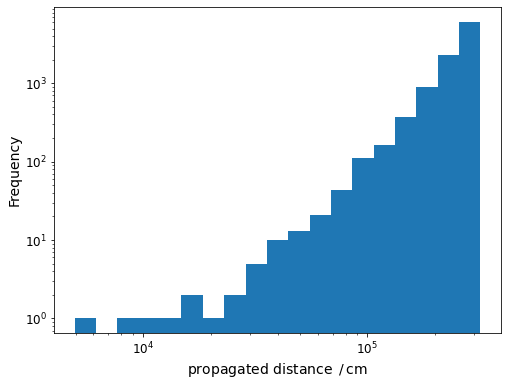

In [10]:
STATISTICS = int(1e4)
final_energy = 1e7 # final energy in MeV
distances = []

for i in tqdm(range(STATISTICS)):
    track = prop.propagate(init_state, 1e20, 1e4) # propagate the initial state until particle reached 1e4 MeV
    distance_at_track_end = track.track_propagated_distances()[-1] # save propagated distance at the end of the track
    distances.append(distance_at_track_end)
    
bins = np.geomspace(min(distances), max(distances), 20)
plt.xscale('log')
plt.xlabel(r'propagated distance $\,/\, \mathrm{cm} $')
plt.ylabel("Frequency")
_ = plt.hist(distances, bins=bins, log=True) 